In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline
import random
import os

from keras.layers import Input, Dense
from keras.models import Model, Sequential

from sklearn.model_selection import train_test_split
from sklearn import metrics

from IPython.display import display, clear_output
from PIL import Image, ImageSequence

In [2]:
!nvidia-smi -L # list GPUs available

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-a8053574-4128-877c-acfd-80334fa7cd5d)


In [3]:
!export CUDA_VISIBLE_DEVICES=0

In [2]:
mass_range = [0,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6]

x = {}
x_array_read = np.load("x_array_order.npy",allow_pickle=True)
mycounter = -1
for m1 in mass_range:
    for m2 in mass_range:
        if (m1==0 and m2>0 or m2==0 and m1>0):
            continue
        mycounter+=1
        x[m1,m2] = x_array_read[mycounter]

In [ ]:
np.shape(x[0,0,qq, noise])

Below we evaluate every point in our discritized space of weights and store to a dictionary, evaluation can be stopped at any point, saving after every signal fraction

In [13]:
import time
start_time = time.time()

def evaluate_loss_landscape(model, m1, m2):
    
    Nfeatures = 6
    #check if loss dictionary exists, if it does load it, if not create empty one
    dir_path = os.getcwd()
    file_name = f"z_allm1m2_{Nfeatures}FeaturesHD.npy"
    file_path = os.path.join(dir_path, file_name)
    
    if os.path.exists(file_path):
        z = np.load(file_name, allow_pickle = True).item()
    else:
        print("Dictionary doesn't exist, creating one...")
        z = {}
    #varying sigfrac, fixed mass pair
    
    losses_list = []

    epsilon = 1e-6
    sig_space = np.logspace(-3, -1, 10)
    
    #if we want a specific sigfrac
    #sig_space = [sig_space[15]]
    
    start = 0.5
    end = 6
    step = 0.25

    weight_list = np.arange(start, end + step, step)
    
    for sig in sig_space:
        print("Signal Fraction: ", sig)
        for w1 in weight_list:
            for w2 in weight_list:
                #print(w1, w2)
                sigfrac = sig

                for l in model.layers:
                    l.trainable=False

                inputs_hold = tf.keras.Input(shape=(1,))
                simple_model = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w1))(inputs_hold)
                model3 = Model(inputs = inputs_hold, outputs = simple_model)

                inputs_hold2 = tf.keras.Input(shape=(1,))
                simple_model2 = Dense(1,use_bias = False,activation='relu',kernel_initializer=tf.keras.initializers.Constant(w2))(inputs_hold2)
                model32 = Model(inputs = inputs_hold2, outputs = simple_model2)

                inputs_hold3 = tf.keras.Input(shape=(1,))
                simple_model3 = tf.exp(Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(-1))(inputs_hold3))
                model33 = Model(inputs = inputs_hold3, outputs = simple_model3)

                inputs = tf.keras.Input(shape=(Nfeatures,))
                inputs2 = tf.keras.layers.concatenate([inputs,model3(tf.ones_like(inputs)[:,0]),model32(tf.ones_like(inputs)[:,0])])
                hidden_layer_1 = model(inputs2)
                LLR = hidden_layer_1 / (1.-hidden_layer_1 + epsilon)
                LLR_xs = 1.+sigfrac*LLR - sigfrac
                #LLR_xs = 1.+model33(tf.ones_like(inputs)[:,0])*LLR
                ws = LLR_xs / (1.+LLR_xs+0.0001)
                model_all2 = Model(inputs = inputs, outputs = ws)
                model_all2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01))

                m1 = m1
                m2 = m2
                
                #if computed this mass pair, break
                
                key = (sigfrac,m1,m2)
                if key in z:
                    break

                test_background = int(1/2 *len(x[0,0, qq]))
                train_background = int(1/4 * len(x[0,0,qq]))
                train_data = int(1/4 * len(x[0,0,qq]))
                train_reference = int(1/4 * len(x[0,0,qq]))
                #signal
                test_signal_length = int(1/2*len(x[m1,m2,qq]))
                sig_frac = sigfrac

                #randomize signal events
                #random_test_signal_length = random.randint(0, test_signal_length - 1)
                N = int(1/4 * (len(x[0,0,qq])))
                signal = x[m1, m2,qq][test_signal_length:test_signal_length + int(sigfrac*N)]

                x_vals_ = np.concatenate([x[0,0,qq][test_background:],signal])
                y_vals_ = np.concatenate([np.zeros(train_reference),np.ones(train_data),np.ones(len(signal))])

                X_train_, X_val_, Y_train_, Y_val_ = train_test_split(x_vals_, y_vals_, test_size=0.5, random_state = 42)
                
                with tf.device('/GPU:0'):
                    loss = model_all2.evaluate(X_val_, Y_val_, verbose = 0)
                losses_list.append(loss)
                
        end_time = time.time()
        elapsed_time = round(end_time - start_time, 3)
        print(f"Time taken: {elapsed_time} seconds")
        if key in z:
            print("Landscape for m1 = {} ".format(m1) + "and " + "m2 = {} ".format(m2) +" already exists for " + "{}".format(sigfrac) + " signal fraction")
        else:
            z[sigfrac, m1, m2] = losses_list
            losses_list = []
            np.save(file_name, z)
end_time_total = time.time()

elapsed_time_total = round(end_time_total - start_time, 3)
print(f"Total elapsed time: {elapsed_time_total} seconds")

Signal Fraction:  0.001
Signal Fraction:  0.0012742749857031334
Signal Fraction:  0.001623776739188721
Signal Fraction:  0.00206913808111479
Signal Fraction:  0.0026366508987303583
Signal Fraction:  0.003359818286283781
Signal Fraction:  0.004281332398719396
Signal Fraction:  0.00545559478116852
Signal Fraction:  0.0069519279617756054
Signal Fraction:  0.008858667904100823
Signal Fraction:  0.011288378916846888
Signal Fraction:  0.01438449888287663
Signal Fraction:  0.018329807108324356
Signal Fraction:  0.023357214690901212
Signal Fraction:  0.029763514416313176
Signal Fraction:  0.0379269019073225
Signal Fraction:  0.04832930238571752
Signal Fraction:  0.06158482110660261
Signal Fraction:  0.07847599703514611
Signal Fraction:  0.1


In [3]:
loss_values = list(z[sig_space[0], 1, 5.5])

plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=loss_values);

In [ ]:
def loss_landscape_nofit(sigfrac, m1, m2, z, step=0.25):
    start = 0.5
    end = 6
    step = step
    
    weight_list = np.arange(start, end + step, step)
    grid_axes = [(w1, w2) for w1 in weight_list for w2 in weight_list]
    w1_values, w2_values = zip(*grid_axes)

    loss_values = list(z[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)
    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    bins = int(np.sqrt(len(z[sigfrac, m1, m2])))

    star1_coords = (m1, m2)
    star2_coords = (m2, m1)

    plt.figure(figsize=(8, 6))
    h = plt.hist2d(w1_values, w2_values, bins=(bins, bins), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.colorbar(label='Loss (BCE)')
    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('6 Features (m1 = {} | m2 = {}) sigfrac: {:.4f}'.format(m1, m2, sigfrac))
    plt.legend()
    plt.show()
    
    return h
loss_landscape_nofit(0.001, 3, 3, z_allm1m2_6HD);

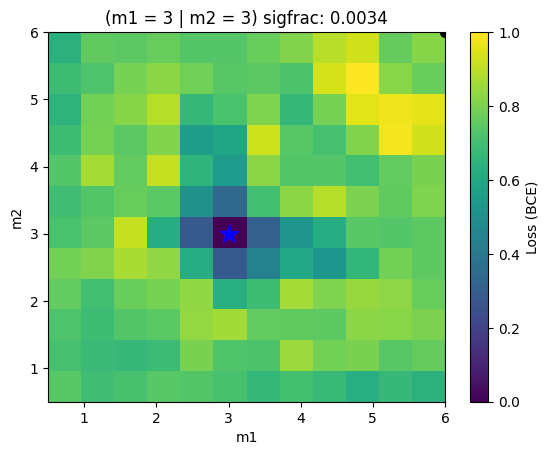

In [125]:
def loss_landscape_2D(sigfrac, m1, m2, w1_out, w2_out, z):
    m1_values, m2_values = zip(*grid_axes.keys())

    loss_values = list(z[sigfrac, m1, m2])
    min_loss = min(loss_values)
    max_loss = max(loss_values)

    star1_coords = (m1, m2)  
    star2_coords = (m2, m1)
    fitoutput_coords = (w1_out, w2_out)

    normalized_loss = [(x - min_loss) / (max_loss - min_loss) for x in loss_values]
    
    h = plt.hist2d(m1_values, m2_values, bins=(12, 12), cmap='viridis', weights=normalized_loss)
    plt.scatter(*star1_coords, c='red', marker='*', s=200, label='Star 1')
    plt.scatter(*star2_coords, c='blue', marker='*', s=200, label='Star 2')
    plt.scatter(*fitoutput_coords, c='black', marker='.', s=200, label='fit_output')
    plt.colorbar(label='Loss (BCE)')

    plt.xlabel('m1')
    plt.ylabel('m2')
    plt.title('(m1 = {} | m2 = {}) sigfrac: {:.4f}'.format(m1, m2, sigfrac))
    return h

loss_landscape_2D(sig_space[5], 3, 3, 6, 6, z);

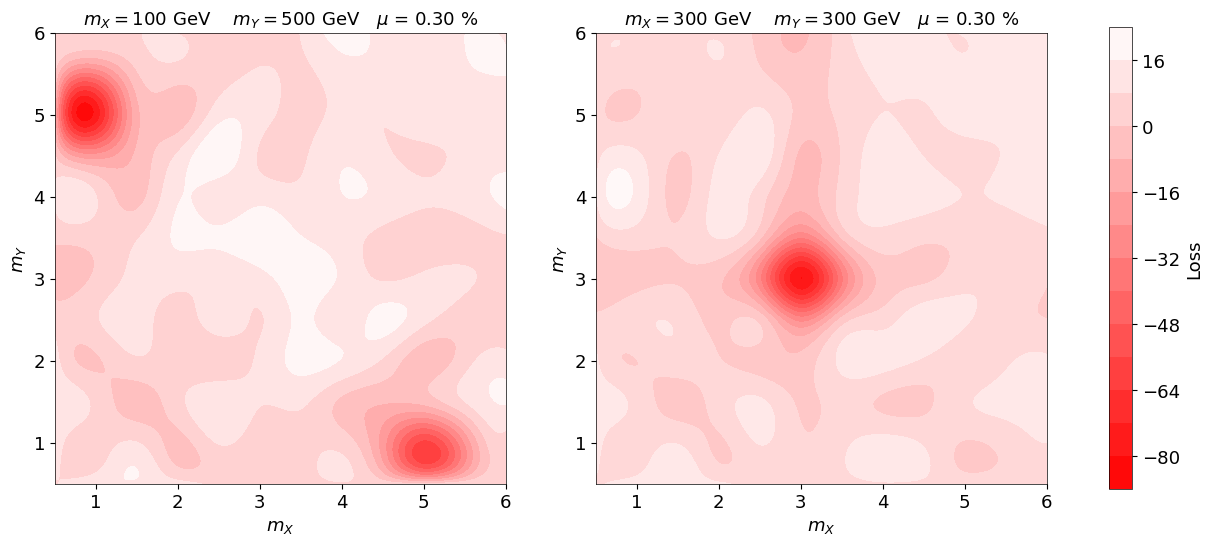

In [6]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

sigspace = np.logspace(-3.5, -1.3, 10)
sigfrac = sigspace[4]
decay = "qqq"
m1, m2 = 1, 5
m1_2, m2_2 = 3, 3
z1 = np.load("data/landscapes/z_6_4_15_0.5_qqq_extra_23prong_fixedNEW_False.npy", allow_pickle = True).item()
z2 = np.load("data/landscapes/z_6_4_33_0.5_qqq_extra_23prong_fixedNEW_False.npy", allow_pickle = True).item()
sigspace = np.logspace(-3.5, -1.3, 10)
save = False

start = 0.5
end = 6
step = 0.5

weight_list = np.arange(start, end + step, step)

x_values = weight_list
y_values = weight_list

x, y = np.meshgrid(x_values, y_values)

loss_values_flat = z1[sigfrac, m1, m2, decay]
loss_values = np.transpose(np.array(loss_values_flat).reshape(x.shape))

interp_spline = RectBivariateSpline(x_values, y_values, loss_values, s = 0)

xi, yi = np.meshgrid(np.linspace(min(x_values), max(x_values), 1000), np.linspace(min(y_values), max(y_values), 1000))
zi = interp_spline(xi[0, :], yi[:, 0])

loss_values_flat2 = z2[sigfrac, m1_2, m2_2, decay]
loss_values2 = np.transpose(np.array(loss_values_flat2).reshape(x.shape))

interp_spline2 = RectBivariateSpline(x_values, y_values, loss_values2, s = 0)

xi2, yi2 = np.meshgrid(np.linspace(min(x_values), max(x_values), 1000), np.linspace(min(y_values), max(y_values), 1000))
zi2 = interp_spline2(xi2[0, :], yi2[:, 0])

#2d projection
fig = plt.figure(figsize=(16, 6))
gs = GridSpec(1, 2, figure=fig)
colors = [(1, 0, 0), (1, 1, 1)]

cmap = LinearSegmentedColormap.from_list('blue_white', colors)  
#cmap = "viridis"

fontsize = 13
levels = 15
zoffset = (zi - np.log(2)) * 1000000
zoffset2 = (zi2 - np.log(2)) * 1000000

ax0 = fig.add_subplot(gs[0, 0])
h1 = ax0.contourf(xi, yi, zoffset, cmap=cmap, levels=levels)
ax0.set_aspect("equal")
ax0.set_title(f"$m_X = {m1*100}$ GeV $\quad m_Y = {m2*100}$ GeV" + f"$\quad \\mu$ = {sigfrac * 100:.2f} %", fontsize=fontsize)
ax0.set_xlabel(r"$m_{X}$", fontsize=fontsize)
ax0.set_ylabel(r"$m_{Y}$", fontsize=fontsize)
ax0.tick_params(axis='x', labelsize=fontsize)
ax0.tick_params(axis='y', labelsize=fontsize)

for spine in ax0.spines.values():
    spine.set_linewidth(0.5)

ax1 = fig.add_subplot(gs[0, 1])
h2 = ax1.contourf(xi2, yi2, zoffset2, cmap=cmap, levels=levels)
ax1.set_aspect("equal")
ax1.set_title(f"$m_X = {m1_2*100}$ GeV $\quad m_Y = {m2_2*100}$ GeV" + f"$\quad \\mu$ = {sigfrac * 100:.2f} %", fontsize=fontsize)
ax1.set_xlabel(r"$m_{X}$", fontsize=fontsize)
ax1.set_ylabel(r"$m_{Y}$", fontsize=fontsize)
ax1.tick_params(axis='x', labelsize=fontsize)
ax1.tick_params(axis='y', labelsize=fontsize)

for spine in ax1.spines.values():
    spine.set_linewidth(0.5)

cbar = fig.colorbar(h1, ax=[ax0, ax1], location='right', shrink=1)
cbar.set_label('Loss', fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

for spine in cbar.ax.spines.values():
    spine.set_linewidth(0.5)

if save == True:
    plt.savefig(f'plots/losslandscapes_{sigfrac:.4f}transposed.pdf', dpi=450, bbox_inches='tight', format='pdf')

In [1]:
def animate(sigfrac, m1, m2, w1, w2, epochs, z):
    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

        plt.figure()
        loss_landscape(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)
        plt.show()
        clear_output(wait=True)
        
    loss_landscape(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)
    print("Final weight coordinates: w1 = {} ".format(w1_fit_coord) + " w2 = {} ".format(w2_fit_coord))
        
sigfrac = sig_list[19]
w1, w2 = 2, 3
m1, m2 = 3, 4.5
epochs = 50
animate(sigfrac, m1, m2, w1, w2, epochs, z345)

In [2]:
def animate_random(sigfrac, m1,m2, w1, w2, epochs, z):
    print(f"Initial Weights: {w1} {w2}")
    animate(sigfrac, m1, m2, w1, w2, epochs, z)
    
sigfrac = 0.05
random_number1 = random.uniform(0.1, 6.0)
random_number2 = random.uniform(0.1, 6.0)
m1, m2 = 1, 5.5
epochs = 50

animate_random(sigfrac, m1,m2, random_number1, random_number2, 50, z)

In [169]:
#save images to make them gifs
def create_gif_fitout(sigfrac, m1, m2, w1, w2, z, epochs):
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)

    for key, value in train_wsmodel(sigfrac, m1, m2, w1, w2, epochs).items():
        w1_fit_coord = value[0]
        w2_fit_coord = value[1]

        loss_landscape_2D(sigfrac, m1, m2, w1_fit_coord, w2_fit_coord, z)

        image_path = os.path.join(output_directory, f'hist_{key}.png')
        plt.savefig(image_path)
        plt.close()

        clear_output(wait=True)
        
    #make the gif
    frames = []

    image_dir = '2dhist_images'
    image_files = os.listdir(image_dir)

    image_files = sorted([filename for filename in os.listdir(image_dir) if filename.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))
    for filename in image_files:
        image = Image.open(os.path.join(image_dir, filename))
        frames.append(image)
        os.remove(image_dir+"/"+filename)

    output_gif_filename = f'{sigfrac, m1, m2, w1, w2}.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=200, loop=0)

In [193]:
w1 = random.uniform(0.5, 6.0)
w2 = random.uniform(0.5, 6.0)

print(w1, w2)
sigfrac = sig_space[10]
m1 = 3
m2 = 4.5
epochs = 50
create_gif_fitout(sigfrac, m1, m2, w1, w2, z_allm1m2, epochs)

3.736706332731714 3.002639396491747
Signal Fraction:  0.011288378916846888
30/30 [==============================] - 0s 7ms/step - loss: 0.6916 - val_loss: 0.6915
3 4.5 4.562472 2.8867893


In [172]:
sig_space = np.logspace(-3, -1, 20)
for sigfrac in sig_space:
    m1, m2 = 1, 5.5
    w1 = round(random.uniform(0.5, 6.0),3)
    w2 = round(random.uniform(0.5, 6.0),3)
    epochs = 50
    frames = create_gif_fitout(sigfrac, m1, m2, w1, w2, z_allm1m2, epochs)

In [1]:
def create_gif_nofit(m1, m2, z):
    
    output_directory = '2dhist_images'
    os.makedirs(output_directory, exist_ok=True)
    
    sig_space = np.logspace(-3, -1 , 20)
    
    frames = []
    for sb in sig_space:
    
        loss_landscape_nofit(sb, m1, m2, z)

        image_path = os.path.join(output_directory, f'hist_{sb}.png')
        plt.savefig(image_path)
        plt.close()
        clear_output(wait=True)

        frames.append(Image.open(image_path))

    output_gif_filename = f'sigspace{m1}{m2}fixed.gif'
    frames[0].save(output_gif_filename, save_all=True, append_images=frames[1:], duration=400, loop=0)